# Lithium Oven Optic 6

In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from ionization import ionization
from lens import profile
from lens import design
import matplotlib.pyplot as plt
plt.style.use('notes')

path = '/mnt/md0/Data/rariniello/Lithium_Oven/Lithium_Oven_Optic_6/'
lam = 0.796
# All length units are in um

75um radius Bessel to make the widest fully ionized Bessel beam possible (see Plasma Width for details). Slightly ramping intensity profile for best performance. Plasma is approximatly 300um wide and fully ionized in the bulk. Optic 6 is meant to be the first iteration we actually make a physical version of.

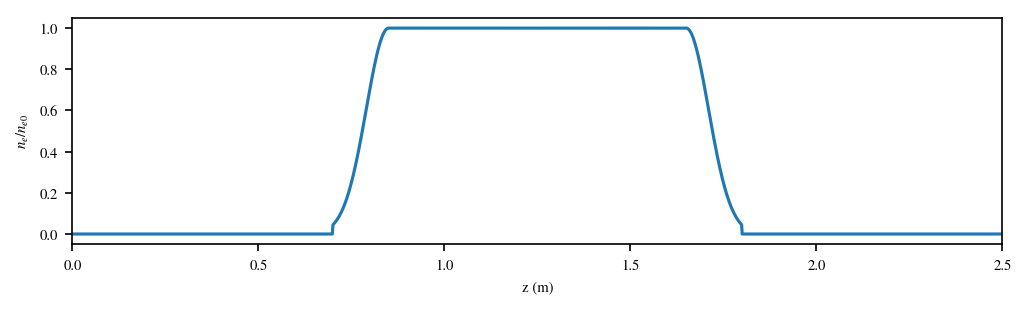

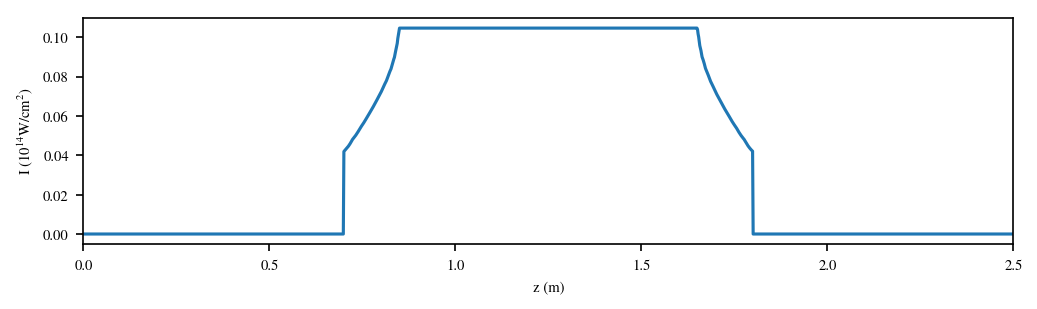

Plasma starts at 0.32m and ends at 2.25m


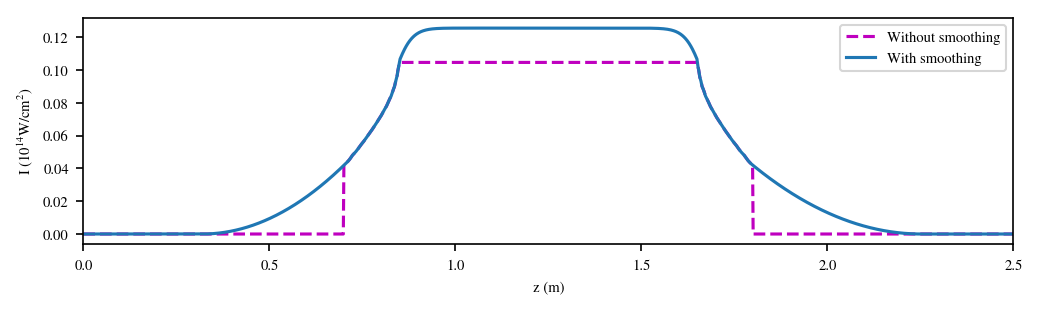

In [2]:
length = 80e4
width = 75
Nz = 2**16
Z = 100e6
z0 = 0.85e6
xlim = [0, 2.5]
tau = 30 # RMS pulse length in fs
ion = {'atom' : ionization.Li,
       'tau' : tau,
       'type' : 'gaussian'}
z, I_la = profile.cutoff_gaussian_intensity(Nz, Z, z0, length, 15e4, 6e4, 15e4, 6e4, ion, 8, 0.4, path, xlim)

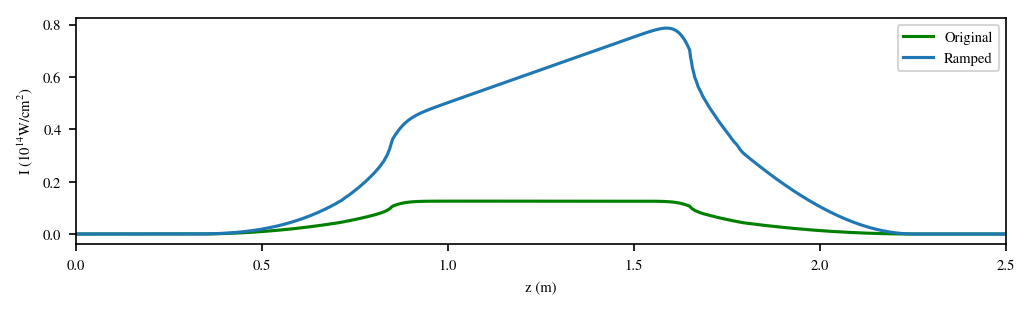

In [3]:
# Add a ramped intensity profile
I_ramped = abs(4*I_la*(1e-6*(z-1e6)+1))
plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, I_la, 'g')
plt.plot(z/1e6, I_ramped)
plt.legend(['Original', 'Ramped'])
plt.xlabel(r'z (m)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(xlim)
plt.show()
np.save(path+'intensity.npy', I_ramped)
np.save(path+'z.npy', z)

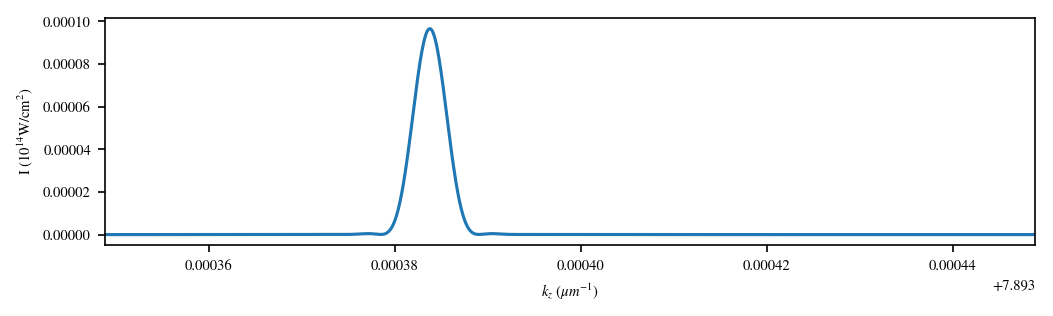

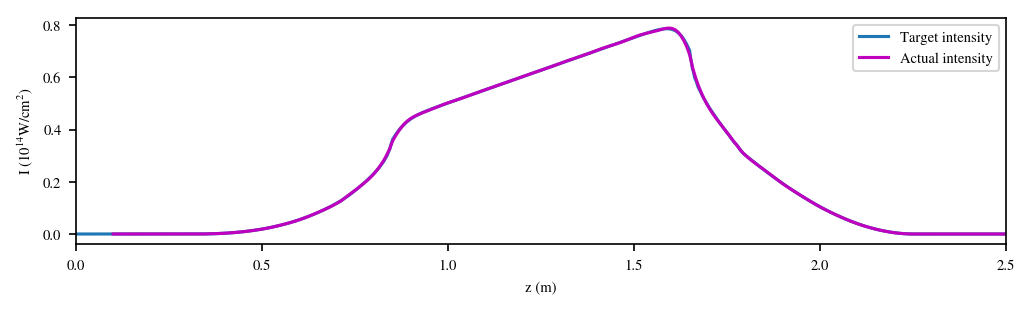

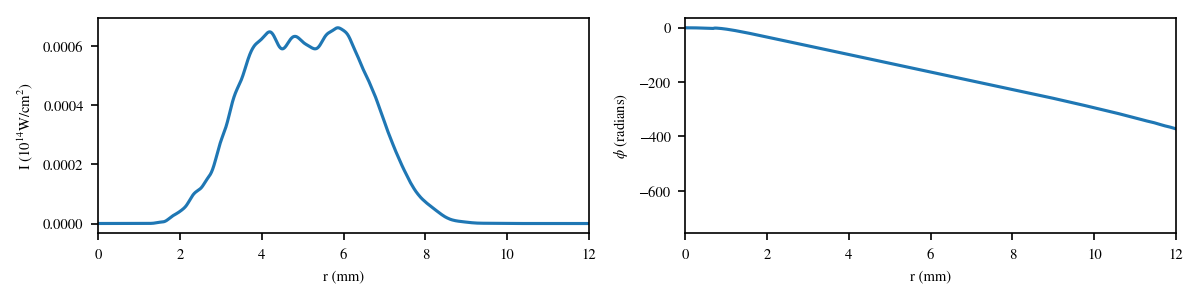

In [4]:
r, E = design.calculate_tran_field(z, I_ramped, 20e3, width, lam, path, 10e-5, xlim, [0, 12])

In [5]:
# Create the gas density the laser is going into
ne0 = 3.4e16/1e17
sim_start, n_plot, n = profile.lithium_oven_profile(z, 1.25e6, ne0)
sim_length = 80e4
np.save(path+'sim_size.npy', [sim_start, sim_length])

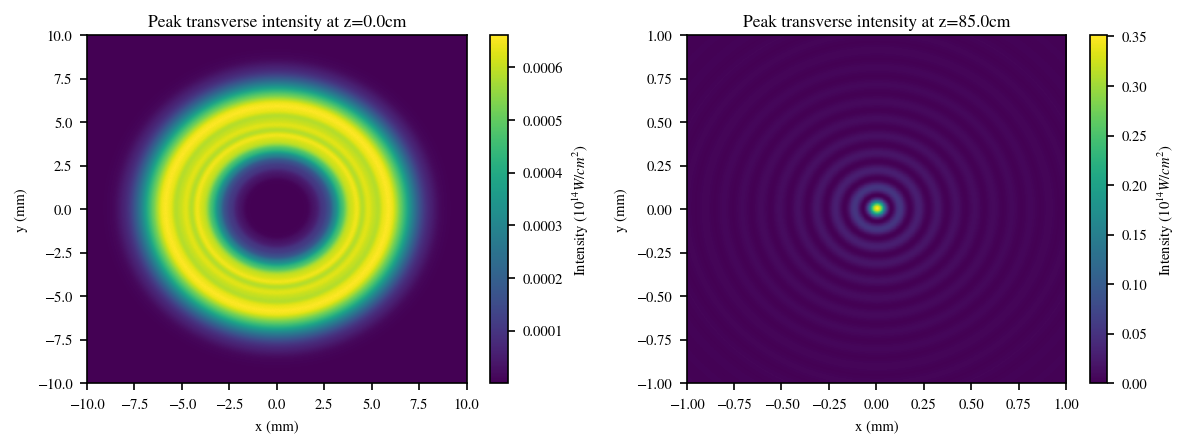

In [6]:
X = 20e3
Nx = 2**13
beam0, pulseParams = design.propagate_to_start(r, E, sim_start, X, Nx, path, lam, tau, 20, [-1, 1])

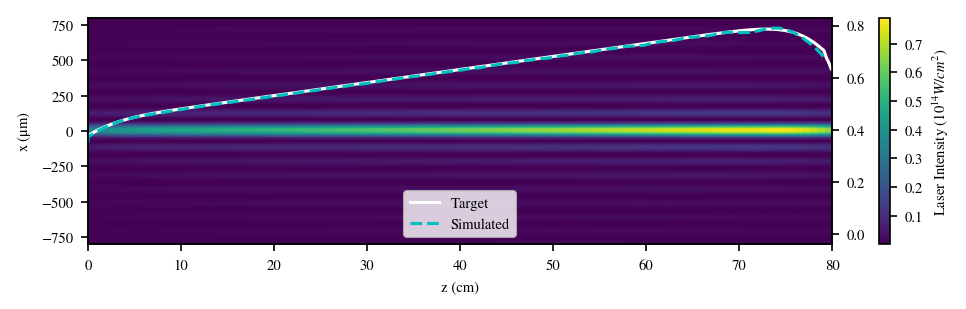

In [ ]:
Nx = 2**11
Nz = 100
X = 10e3
design.domain_test(X, Nx, sim_length, Nz, beam0, pulseParams, z, I_ramped, sim_start, [-800, 800])

In [ ]:
Nx = 2**11
Nz = 400
ext = [0, sim_length/1e4, -X/2, X/2]
pulse, I, ne = design.plasma_refraction(X, Nx, sim_length, Nz, beam0,pulseParams,ionization.Li,n, sim_start, 1)
design.plot_plasma_density(pulse, ne, ne0, ext, lines=[20, 40, 60])

In [ ]:
design.plot_plasma_density(pulse, ne, ne0, ext, lines=[20, 40, 60])

In [ ]:
design.plot_laser_plasma(I, ne, ext)